## Neuronas biológicas

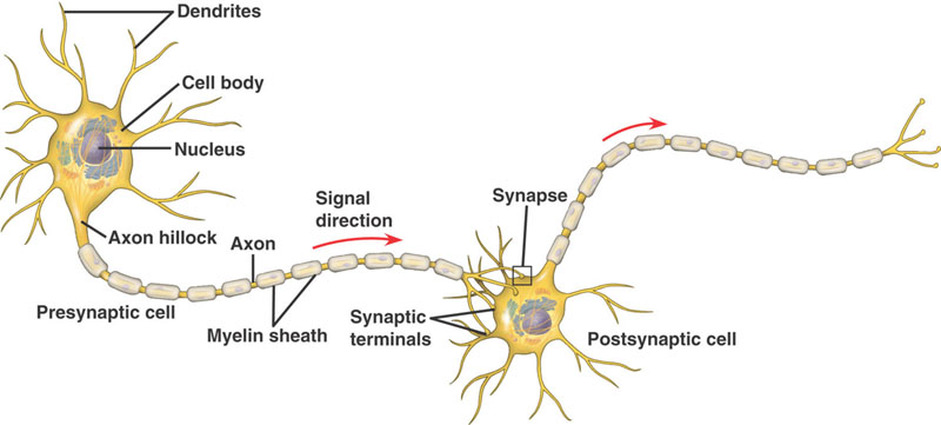

In [50]:
from IPython.display import Image
Image(filename='imgs/neurons.jpg', width=600)

## Simplificación como una neurona artificial

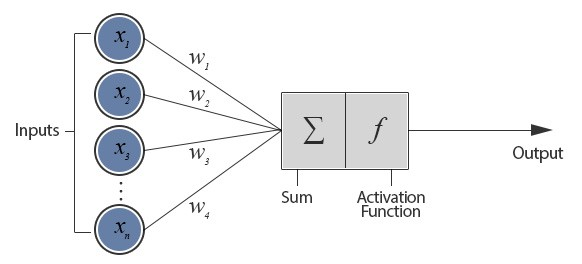

In [54]:
Image(filename='imgs/neuron.jpeg', width=600)

## Red de neuronas artificiales

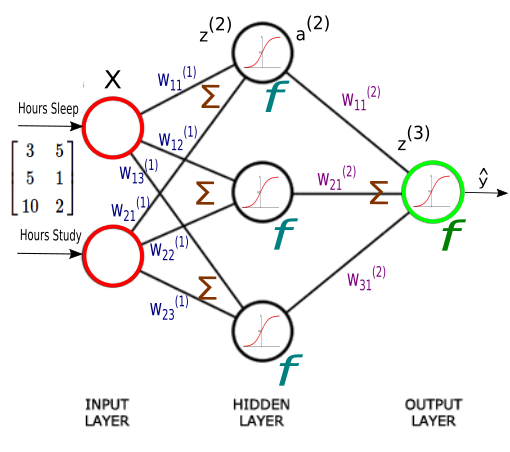

In [52]:
Image(filename='imgs/NN-with-components-w11-etc.png', width=400)

## El Perceptrón original

https://www.wikiwand.com/en/Perceptron

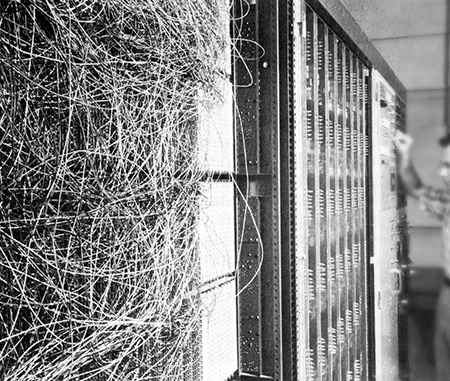

In [214]:
Image(filename='imgs/perceptron.jpg', width=500)

## Formulación 

**Predicción**
$$\hat{y} = \text{sigmoid}(\mathbf{W}_2 \cdot \tanh(\mathbf{x^T} \cdot \mathbf{W}_1 + \mathbf{b}_1) + b_2)$$

y recuerda que $\text{sigmoid}(z) = \frac{1}{1+e^{-z}}$

**Coste**
$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 + \lambda \left[ || \mathbf{b}_1||^2 + b_2^2 + ||\mathbf{W}_1||^2 + ||\mathbf{W}_2||^2\right]$$

observa que la función de coste contiene un conjunto de términos regulados por $\lambda$ (y que están fuera de la sumatoria). Dado un vector o matriz $\mathbf{T}$, su norma al cuadrado se denota por $||\mathbf{T}||^2 \in \mathbb{R}$ y se calcula elevando todos sus elementos al cuadrado y obteniendo su suma. Este $\lambda$ es el argumento `reg` de la clase `SLP`.

Universal Approximation Theorem https://www.wikiwand.com/en/Universal_approximation_theorem


## Implementación

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.datasets import make_moons
import mlutils
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


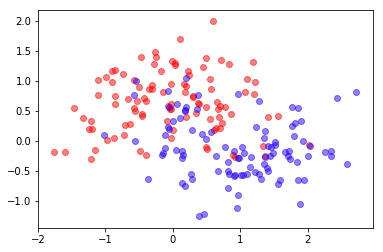

In [7]:
X,y = make_moons(200,noise=.4)
mlutils.plot_2Ddata(X,y)

In [372]:
reload(mlutils)
class SLP:

    def __init__(self, h_units, reg=0, init_params=None):
        self.h_units = h_units
        self.reg     = reg
        self.init_params = init_params

    def sigm(self, x):
        return 1/(1+np.exp(-x))

    def encode(self, b1, b2, W1, W2): 
        return np.array(list(b1)+[b2]+list(W1.flatten())+list(W2.flatten()))

    def decode(self, params, nb_cols):
        b1 = params[:self.h_units]
        b2 = params[self.h_units]
        t = self.h_units+1+nb_cols*self.h_units
        W1 = params[self.h_units+1:t].reshape(nb_cols, self.h_units)
        W2 = params[t:].reshape(-1,1)
        return b1, b2, W1, W2

    def y_hat(self, X, params):
        b1,b2,W1,W2 = self.decode(params, X.shape[1])
        return self.sigm(np.tanh(X.dot(W1)+b1).dot(W2)+b2)[:,0]

    def k(self, X, y, params):
        b1,b2,W1,W2 = self.decode(params, X.shape[1])
        return (self.sigm(np.tanh(X.dot(W1)+b1).dot(W2)+b2)-y)
    
        
    def fit(self, X,y, verbose=False):

        self.init_params = np.random.random(1+self.h_units*2+self.h_units*X.shape[1]) \
                           if self.init_params is None else self.init_params
        
        def cost(p):
            return np.mean ( (self.y_hat(X, p) - y)**2 ) + self.reg * np.sum(p**2)

        r = minimize(cost, self.init_params, method="BFGS")
        self.params = r.x

    def predict(self, X):
        return (self.y_hat(X, self.params)>.5)*1

    def score(self, X,y):
        return np.sum(self.predict(X)==y)*1./len(X)

    def draw(self, ax=None):
        ax = plt.figure(figsize=(4,4)).add_subplot(111) if not ax else ax
        mlutils.draw_neural_net(ax, .1, .9, .1, .9, [2, self.h_units, 1])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis("off")

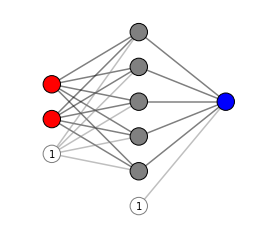

In [373]:
d = np.loadtxt("/tmp/xx")
X = d[:,:-1]
y = d[:,-1]
slp = SLP(h_units=5)
slp.fit(X,y)
slp.draw()

(0.491925, 0.508075)

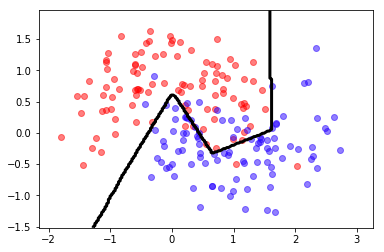

In [374]:
mlutils.plot_2Ddata_with_boundary(slp.predict, X,y)

 93% (15 of 16) |######################  | Elapsed Time: 0:00:14 ETA:   0:00:03

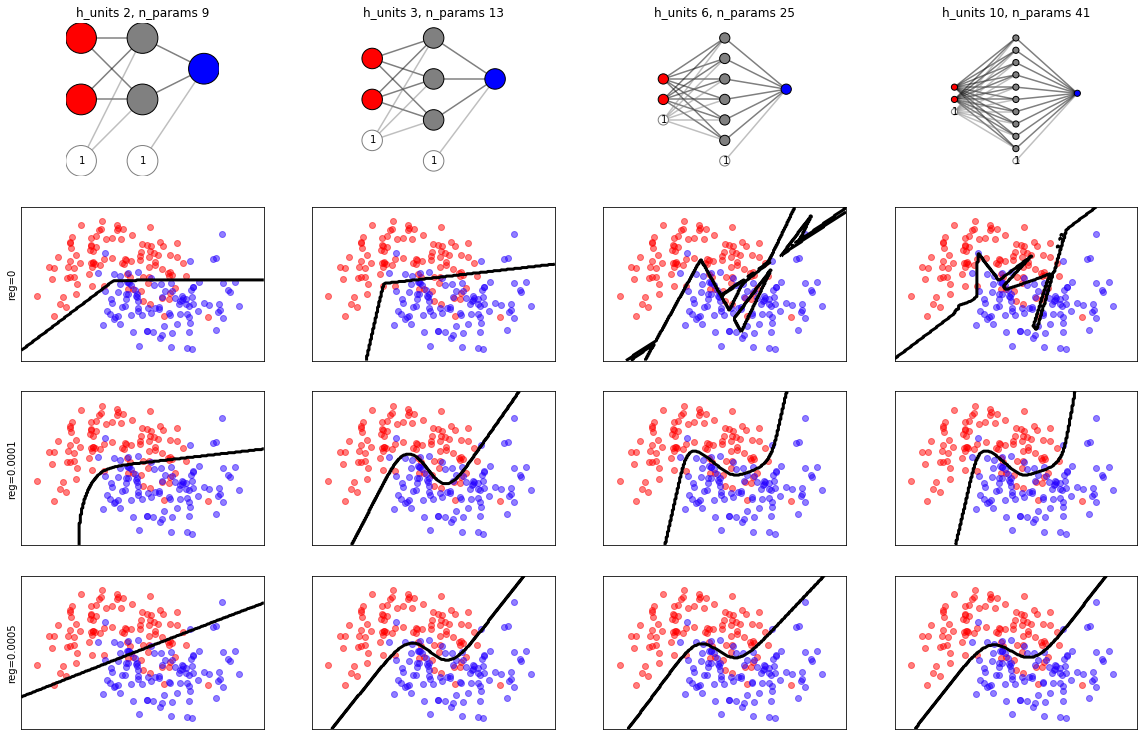

In [359]:
reload(mlutils)
h_units_range = [2,3,6,10]
reg_range     = [0,1e-4,5e-4]

plt.figure(figsize=(20,13))
pbar = mlutils.pbar(max_value=len(h_units_range)*(len(reg_range)+1))
for i, h_units in enumerate(h_units_range):
    ax = plt.subplot(len(reg_range)+1, len(h_units_range), i+1)
    slp = SLP(h_units=h_units, reg=reg)
    slp.draw(ax)
    slp.fit(X,y)
    plt.title("h_units %d, n_params %d"%(h_units, slp.params.shape[0]))
    for j, reg in enumerate(reg_range):
        pbar.update(j+i*len(h_units_range)+1)
        
        plt.subplot( len(reg_range)+1, len(h_units_range), (j+1)*len(h_units_range)+i+1)
        slp = SLP(h_units=h_units, reg=reg)
        slp.fit(X,y)
        mlutils.plot_2Ddata_with_boundary(slp.predict, X, y)
        plt.xticks([]); plt.yticks([])
        if i==0:
            plt.ylabel("reg=%s"%str(reg))